In [72]:
import numpy as np
from numpy import cos, sin, pi, sqrt, arctan2
import matplotlib.pyplot as plt
import healpy as hp
from healpy.newvisufunc import projview, newprojplot

plt.rcParams['figure.dpi'] = 200
REarth = 6.371 * 1e6 #m
c = 3*1e8

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pint
from pint.models import get_model
import glob, os
from astropy import units as u
from astropy.coordinates import SkyCoord

# https://zenodo.org/records/14773896

pfiles = glob.glob('/Users/ic/Desktop/NANOGrav15yr_PulsarTiming_v2.0.1/narrowband/par/*.par')
pfiles = [pf for pf in pfiles if not 'gbt' in pf and not 'ao' in pf]
pnames = [pf[pf.index('par/')+4:pf.index('_PINT')] for pf in pfiles]

RA = {}   # Ascensione Retta (Right Ascension)
DEC = {}  # Declination
DIST = {} # Distanza (in parsec)

for pf in pfiles:
    # Carica il modello PINT
    m = get_model(pf)

    # Estrai le coordinate ICRS (RA e DEC)
    c = m.components['AstrometryEcliptic'].coords_as_ICRS()
    RA[m.PSR.value] = c.ra.deg  # Convertito in gradi
    DEC[m.PSR.value] = c.dec.deg

    # Estrai la distanza (basata sulla parallasse, se disponibile)
    if hasattr(m, 'PX') and m.PX.value > 0:  
        DIST[m.PSR.value] = 1000 / m.PX.value  # Converti la parallasse in parsec
    else:
        DIST[m.PSR.value] = None  # Se la parallasse non è disponibile

# Stampa alcune pulsar con le loro posizioni e distanze
for psr in list(RA.keys())[:5]:  # Mostra solo le prime 5 per esempio
    print(f"Pulsar: {psr} | RA: {RA[psr]:.5f}° | DEC: {DEC[psr]:.5f}° | Distanza: {DIST[psr]} pc")

print("Numero di file .par trovati:", len(pfiles))
print("Lista file:", pfiles)

# converti da parsec a metri
for psr in DIST.keys():
    if DIST[psr] is not None:
        DIST[psr] *= 3.086e16

# converti da rad dec a  theta phi 

theta_pulsar = np.deg2rad(90.0 - np.array(list(DEC.values())))
phi_pulsar = np.deg2rad(list(RA.values()))

# Calcola le coordinate cartesiane

# Converte i dizionari in array NumPy
valid_indices = [psr for psr in DIST if DIST[psr] is not None]  # Escludi None
DIST_array = np.array([DIST[psr] for psr in valid_indices])
theta_pulsar = np.deg2rad(90.0 - np.array([DEC[psr] for psr in valid_indices]))
phi_pulsar = np.deg2rad([RA[psr] for psr in valid_indices])

# Calcola le coordinate cartesiane
x_pulsar = np.sin(theta_pulsar) * np.cos(phi_pulsar)
y_pulsar = np.sin(theta_pulsar) * np.sin(phi_pulsar)
z_pulsar = np.cos(theta_pulsar)
# metti xyz di ogni pulsar nello stesso array 


pulsar_xyz = np.array([x_pulsar, y_pulsar, z_pulsar]).T


2025-02-18 14:18:33.624 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


Pulsar: J0613-0200 | RA: 93.43323° | DEC: -2.01313° | Distanza: 1095.5717225936464 pc
Pulsar: J2234+0611 | RA: 338.59616° | DEC: 6.19131° | Distanza: 1211.5783476863417 pc
Pulsar: J1713+0747 | RA: 258.45639° | DEC: 7.79374° | Distanza: 1200.6457584892041 pc
Pulsar: J1455-3330 | RA: 223.94988° | DEC: -33.51288° | Distanza: 4197.181168130663 pc
Pulsar: J0557+1551 | RA: 89.38104° | DEC: 15.83502° | Distanza: 1051.5046660387802 pc
Numero di file .par trovati: 68
Lista file: ['/Users/ic/Desktop/NANOGrav15yr_PulsarTiming_v2.0.1/narrowband/par/J0613-0200_PINT_20220302.nb.par', '/Users/ic/Desktop/NANOGrav15yr_PulsarTiming_v2.0.1/narrowband/par/J2234+0611_PINT_20220304.nb.par', '/Users/ic/Desktop/NANOGrav15yr_PulsarTiming_v2.0.1/narrowband/par/J1713+0747_PINT_20220309.nb.par', '/Users/ic/Desktop/NANOGrav15yr_PulsarTiming_v2.0.1/narrowband/par/J1455-3330_PINT_20220301.nb.par', '/Users/ic/Desktop/NANOGrav15yr_PulsarTiming_v2.0.1/narrowband/par/J0557+1551_PINT_20220302.nb.par', '/Users/ic/Desktop/

In [76]:
def m_n_Omega_basis(Theta_mesh, Phi_mesh, psi):
        '''
        General polarization angle psi
        '''
        
        n = np.stack([
            np.sin(Phi_mesh), 
            -np.cos(Phi_mesh), 
            np.zeros_like(Theta_mesh)
        ], axis=0)  # Assicura che sia (3, ...)

        m = np.stack([
            np.cos(Phi_mesh) * np.cos(Theta_mesh),
            np.sin(Phi_mesh) * np.cos(Theta_mesh),
            -np.sin(Theta_mesh)
        ], axis=0)  # Assicura che sia (3, ...)

        Omega = np.stack([
            np.cos(Phi_mesh) * np.sin(Theta_mesh),
            np.sin(Phi_mesh) * np.sin(Theta_mesh),
            np.cos(Theta_mesh)
        ], axis=0)  # Assicura che sia (3, ...)

        return m, n, Omega

def e_pol(theta, phi, psi):  

        '''
        Polarization modes in the general orthonormal basis (m,n, Omega)
        '''

        m, n, Omega = m_n_Omega_basis(theta, phi, psi)
        e_plus = np.einsum('i...,k...',m,m)-np.einsum('i...,k...',n,n)
        e_cross = np.einsum('i...,k...',m,n)+np.einsum('i...,k...',n,m)

        return e_plus, e_cross
    
def F(theta, phi, psi, p):
    '''
    Compute the antenna pattern functions for a given direction of the source and polarization angle psi
    Parameters:
    theta, phi: angles of the source
    psi: polarization angle
    p: unit vector of the pulsar [x, y, z]
    '''
    Omega = m_n_Omega_basis(theta, phi, psi)[2]

    D = 0.5 * np.einsum('i..., j... -> ij...', p, p)  / (1 + np.einsum('ijk, ijk -> jk', Omega, p))
    e_plus, e_cross = e_pol(theta, phi, psi)

    F_plus = np.einsum('ijkl, klij -> ', D, e_plus)
    F_cross = np.einsum('ijkl, klij -> ', D, e_cross)  
    return F_plus, F_cross

def k(L, theta, phi, psi, p, f):
    Omega = m_n_Omega_basis(theta, phi, psi)[2]
    return   1 - np.exp( 1j * 2 * np.pi * L * f * (1 + np.einsum('ijk, ijk -> jk', Omega, p))/c)

def gamma_integrand(theta, phi, psi, L1, L2, p1, p2, f):
    F1_plus, F1_cross = F(theta, phi, psi, p1)
    F2_plus, F2_cross = F(theta, phi, psi, p2)
    k1 = k(L1, theta, phi, psi, p1, f)
    k2 = k(L2, theta, phi, psi, p2, f)
    return (F1_plus * F2_plus.conjugate() + F1_cross * F2_cross.conjugate())*k1 *k2

def gamma(L1, L2, p1, p2, f):
    theta = np.linspace(0, np.pi, 100)
    phi = np.linspace(0, 2*np.pi, 100)
    Theta, Phi = np.meshgrid(theta, phi)
    f = f.reshape(len(f), 1, 1)
    p1 = p1.reshape(3, 1, 1)
    p2 = p2.reshape(3, 1, 1)

    integrand = gamma_integrand(Theta, Phi, 0, L1, L2, p1, p2, f)
    integral = np.trapezoid(np.trapezoid(np.sin(Theta) * integrand, theta), phi)
    return np.real(integral)


[-0.05984842  0.99758917 -0.03512848] [ 0.92560095 -0.36281064  0.10784857] 3.380934335923993e+19 3.73893078096005e+19


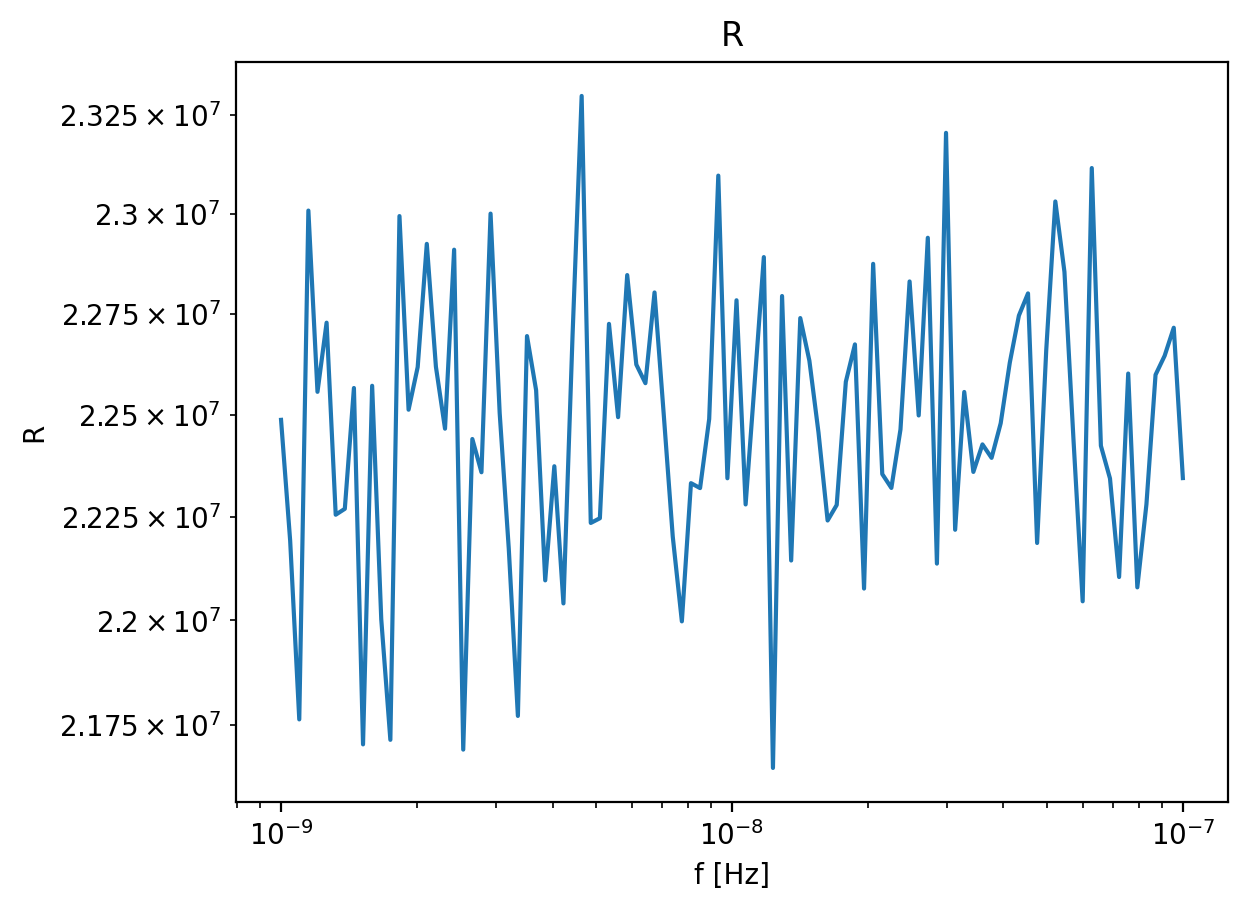

In [77]:
# test per una coppia di pulsar
f = np.logspace(-9, -7, 100)
p1 = pulsar_xyz[0]
p2 = pulsar_xyz[1]
L1 = DIST_array[0]
L2 = DIST_array[1]

print(p1, p2, L1, L2)


R = gamma(L1, L2, p1, p2, f)

plt.plot(f, R)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('R')
plt.title('R')
plt.show()

In [78]:
# overlap per tutte le coppie di pulsar

R = np.zeros((len(DIST_array), len(DIST_array), len(f)))

for i in range(len(DIST_array)):
    for j in range(len(DIST_array)):
        p1 = pulsar_xyz[i]
        p2 = pulsar_xyz[j]
        L1 = DIST_array[i]
        L2 = DIST_array[j]
        R[i, j] = gamma(L1, L2, p1, p2, f)



Text(0, 0.5, 'R')

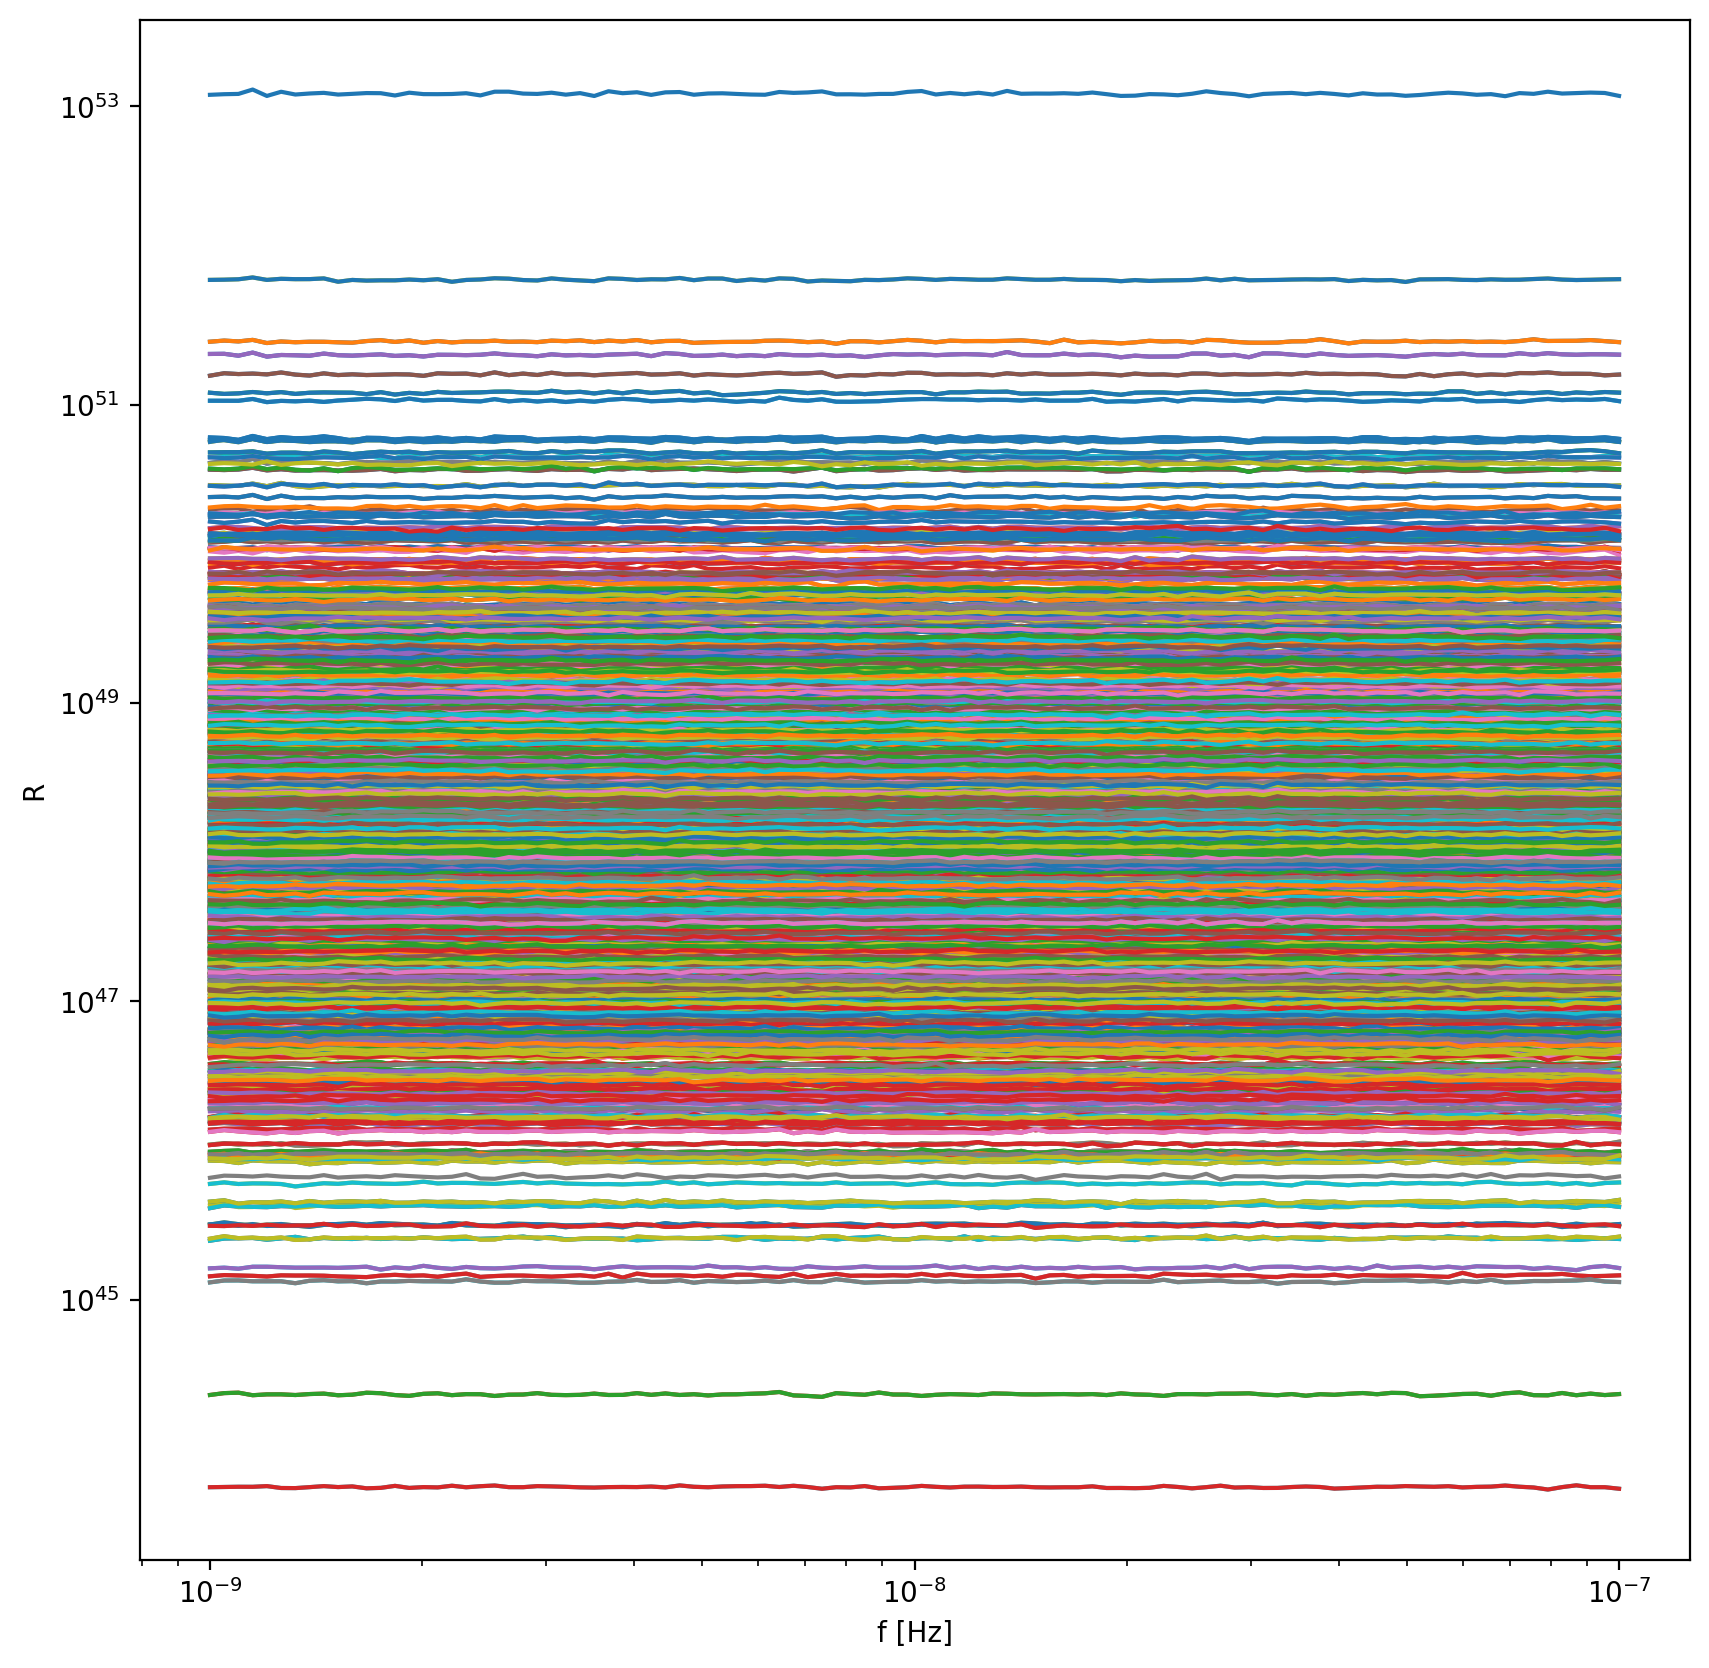

In [ ]:
# plot all the overlaps

plt.figure(figsize=(10, 10))
for i in range(len(DIST_array)):
    for j in range(len(DIST_array)):
        plt.plot(f, R[i, j], label=f'{i} - {j}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('R')